# Imports

In [19]:
import pandas as pd
import boto3
from unidecode import unidecode
from os import environ as env
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import seaborn as sns

# Importação dos Dados

In [20]:

load_dotenv()

access_key = env.get("AWS_ACCESS_KEY_ID")
secret_key = env.get("AWS_SECRET_ACCESS_KEY")
bucket_name = env.get("BUCKET_NAME")

try:
    df_raw = pd.read_csv(
        f"s3://{bucket_name}/anuario-2024-dados_abertos-tabela2-19.csv",
        storage_options={
            "key": access_key,
            "secret": secret_key
        }
    )
    print(f"Dados carregados")

except Exception as e:
    print(f"Erro", e)


Dados carregados


# Limpeza Preliminar
Limpeza simples transformando as colunas em snake case, retirando acentuação e renomeando uma das colunas

In [21]:
def to_snake_case(coluna):
    coluna = unidecode(coluna)
    return coluna.strip().lower().replace(" ", "_")

df_raw.columns = [to_snake_case(coluna) for coluna in df_raw.columns]
df_raw = df_raw.rename(columns={
    'distribuicao_de_royalties_sobre_a_producao_de_petroleo_e_de_gas_natural': 'distribuicao_de_royalties'
    })

# Questões

Formulamos três questões a ser respondidas utilizando nosso conjunto de dados:

1. Qual a diferença total (somando todos os anos) no recebimento dos royalties entre cada estado e os seus municípios?
2. Que região do Brasil recebeu mais royalties e que região recebeu menos?
3. Quais foram os anos de maior arrecadação de Royalties por região?

**Atenção**: precisamos responder essas questões baseando-se nas seguintes manipulações (obrigatoriamente uma por análise, no mínimo):

- Uma cláusula que filtra dados usando ao menos dois operadores lógicos;
- Uma função de agregação;
- Uma função condicional;
- Uma função de conversão;
- Uma função de data;
- Uma função de string.

## Questão 1
### Qual a diferença total (somando todos os anos) no recebimento dos royalties entre cada estado e os seus municípios?

**Manipulações Utilizadas**
- Função de string: `str.endswith()`, `str.extract()` e `str.contains()` foram usadas para manipulação de texto

- Função de conversão: `.astype(float)` para converter os valores para numérico

- Função de agregação: `.sum()` no groupby para somar os royalties

- Função condicional: `.map({True: 'Estado', False: 'Municípios'})` realizou uma estrutura condicional

**Explicação do Código**
- Copiamos o dataframe original com o intuito de usar os dados originais, convertemos a coluna **distribuicao_de_royalties** para float.
    
- Realizamos a filtragem dos beneficiários entre Estado e Municípios com `str.endswith()` e extraímos os valores da coluna **beneficiario** com expressões regulares em uma nova coluna chamada **entidade**.

- Criamos a coluna **tipo** e adicionamos os valores baseados na palavra "Estado". Agregamos os valores por entidade e tipo, somando os valores de royalties com `groupby().sum()`.

- Pivoteamos a tabela usando `pivot()` e criamos a coluna diferenca com o valor absoluto da subtração entre royalties de Estados e Municípios.

- Mantivemos apenas as colunas relevantes (entidade e diferenca) e ordenamos por diferença em ordem decrescente. Reiniciamos o índice para ter uma numeração sequencial limpa com `reset_index(drop=True)`.

- Por fim, o dataframe df_diferenca traz a lista das entidades federativas e das diferenças buscadas.

In [22]:
df1 = df_raw.copy()
df1['distribuicao_de_royalties'] = df1['distribuicao_de_royalties'].str.replace(',', '.').astype(float)

In [23]:
df_aux = df1[df1['beneficiario'].str.endswith(('(Estado)', '(Municípios)'))].copy()
df_aux['entidade'] = df_aux['beneficiario'].str.extract(r'(.*?)\s+\(')
df_aux['tipo'] = df_aux['beneficiario'].str.contains('Estado').map({True: 'Estado', False: 'Municípios'})

df_agrupado = df_aux.groupby(['entidade', 'tipo'], as_index=False)['distribuicao_de_royalties'].sum()

In [24]:
df_pivot = df_agrupado.pivot(index='entidade', columns='tipo', values='distribuicao_de_royalties').fillna(0)
df_pivot['diferenca'] = abs(df_pivot['Estado'] - df_pivot['Municípios'])

df_diferenca = df_pivot.reset_index()[['entidade', 'diferenca']].sort_values('diferenca', ascending=False)
df_diferenca.reset_index(drop=True, inplace=True)

In [25]:
df_diferenca.to_csv('./planilhas/Q1_diferencas_entre_estados_e_municipios.csv', index=False)

Plotagem do gráfico e exportação como "Q1.png".

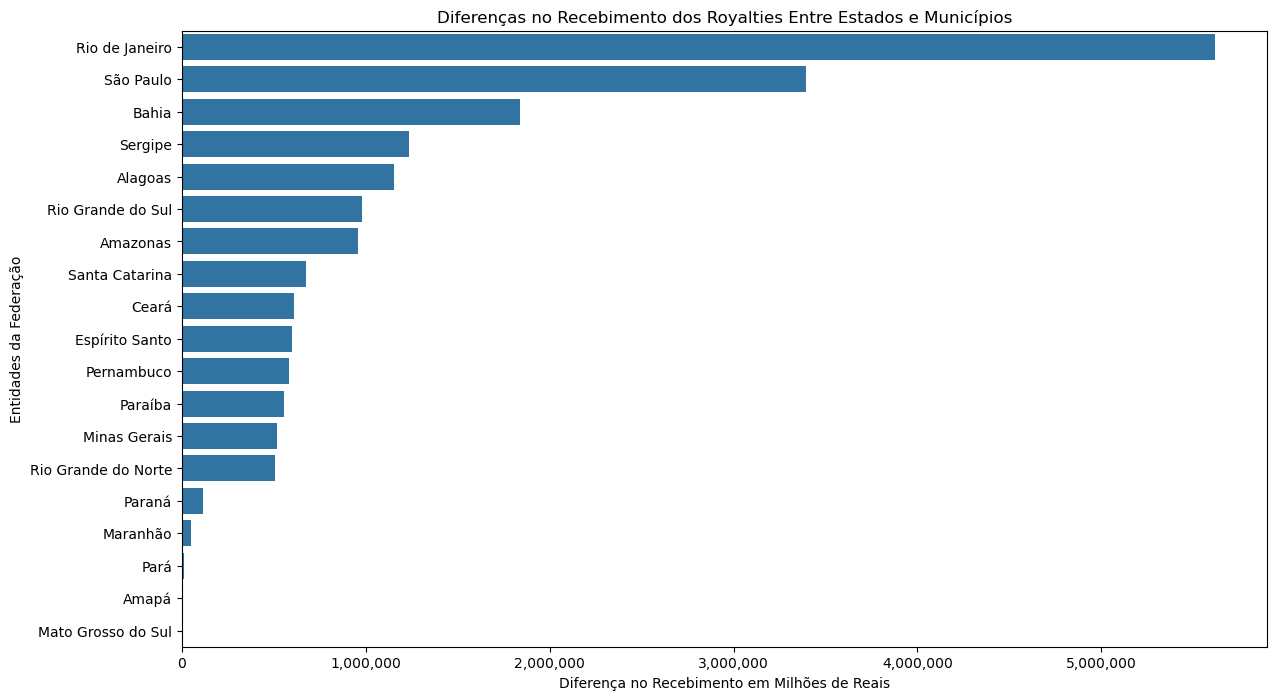

In [26]:
plt.figure(figsize=(14, 8))

ax = (sns.barplot(
    data=df_diferenca,
    x="diferenca",
    y="entidade"
))

ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.title('Diferenças no Recebimento dos Royalties Entre Estados e Municípios')
plt.xlabel('Diferença no Recebimento em Milhões de Reais')
plt.ylabel('Entidades da Federação')

plt.savefig('./img/Q1_diferencas_entre_estados_e_municipios.png',
            dpi=300,
            bbox_inches='tight'
            )  

plt.show()

## Questão 2
### Que região do Brasil recebeu mais royalties e que região recebeu menos?

**Manipulações Utilizadas**
- Função de agregação: `.sum()` para somar os valores de **distribuicao_de_royalties** agrupados por região

- Função condicional: a função lambda com `next()` verifica se a entidade existe nas regiões e retorna a região correspondente ou o valor 'Outros'

- Função de conversão: `.astype(str)` para converter para string na formatação

- Função de string: `.str.endswith()` para filtrar beneficiários que terminam com padrões específicos e `.str.extract()` com expressões regulares para extrair partes do texto

**Explicação do Código**
- Copiamos o dataframe original com o intuito de usar os dados originais, convertemos a coluna **distribuicao_de_royalties** para float.

- Criamos um dicionário `regioes` que organiza todos os estados brasileiros por suas respectivas regiões geográficas (Norte, Nordeste, Centro-Oeste, Sudeste e Sul).

- Filtramos os beneficiários no dataframe **df_aux2** que contém apenas registros onde o beneficiário termina com '(Estado)' ou '(Municípios)' e extraímos o nome das entidades usando expressões regulares.

- Aplicamos uma função lambda que compara cada entidade com o dicionário de regiões, atribuindo a região correspondente ou 'Outros' se não encontrar com a ajuda das funções `next()` e `items()`.

- Agrupamos os dados por região usando a função `groupby()` e soma os valores de distribuição de royalties com a função `sum()`, ordenando do maior para o menor valor e criamos uma coluna **total_formatado** que apresenta os valores em formato brasileiro (R$) com duas casas decimais. convertemos de volta para string com a função `astype(str)`.

In [30]:
df2 = df1.copy()

In [33]:
regioes = {
    'Norte': ['Amazonas', 'Pará', 'Amapá', 'Rondônia', 'Acre', 'Roraima', 'Tocantins'],
    'Nordeste': ['Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba', 'Pernambuco', 
                'Piauí', 'Rio Grande do Norte', 'Sergipe'],
    'Centro-Oeste': ['Mato Grosso', 'Mato Grosso do Sul', 'Goiás', 'Distrito Federal'],
    'Sudeste': ['Espírito Santo', 'Minas Gerais', 'Rio de Janeiro', 'São Paulo'],
    'Sul': ['Paraná', 'Santa Catarina', 'Rio Grande do Sul']
}

In [34]:
df_aux2 = df2[df2['beneficiario'].str.endswith(('(Estado)', '(Municípios)'))].copy()
df_aux2['entidade'] = df_aux2['beneficiario'].str.extract(r'(.*?)\s+\(')

df_aux2['regiao'] = df_aux2['entidade'].apply(
    lambda e: next((r for r, estados in regioes.items() if e in estados), 'Outros')
)

df_resultado = (
    df_aux2
    .groupby('regiao', as_index=False)
    ['distribuicao_de_royalties']
    .sum()
    .sort_values('distribuicao_de_royalties', ascending=False)
)
df_resultado['total_formatado'] = 'R$ ' + df_resultado['distribuicao_de_royalties'].round(2).astype(str)

df_resultado.reset_index(drop=True, inplace=True)

In [35]:
df_resultado.to_csv('./planilhas/Q2_mais_e_menos_royalties.csv', index=False)

Plotagem do gráfico e exportação como "Q2_mais_e_menos_royalties.png"

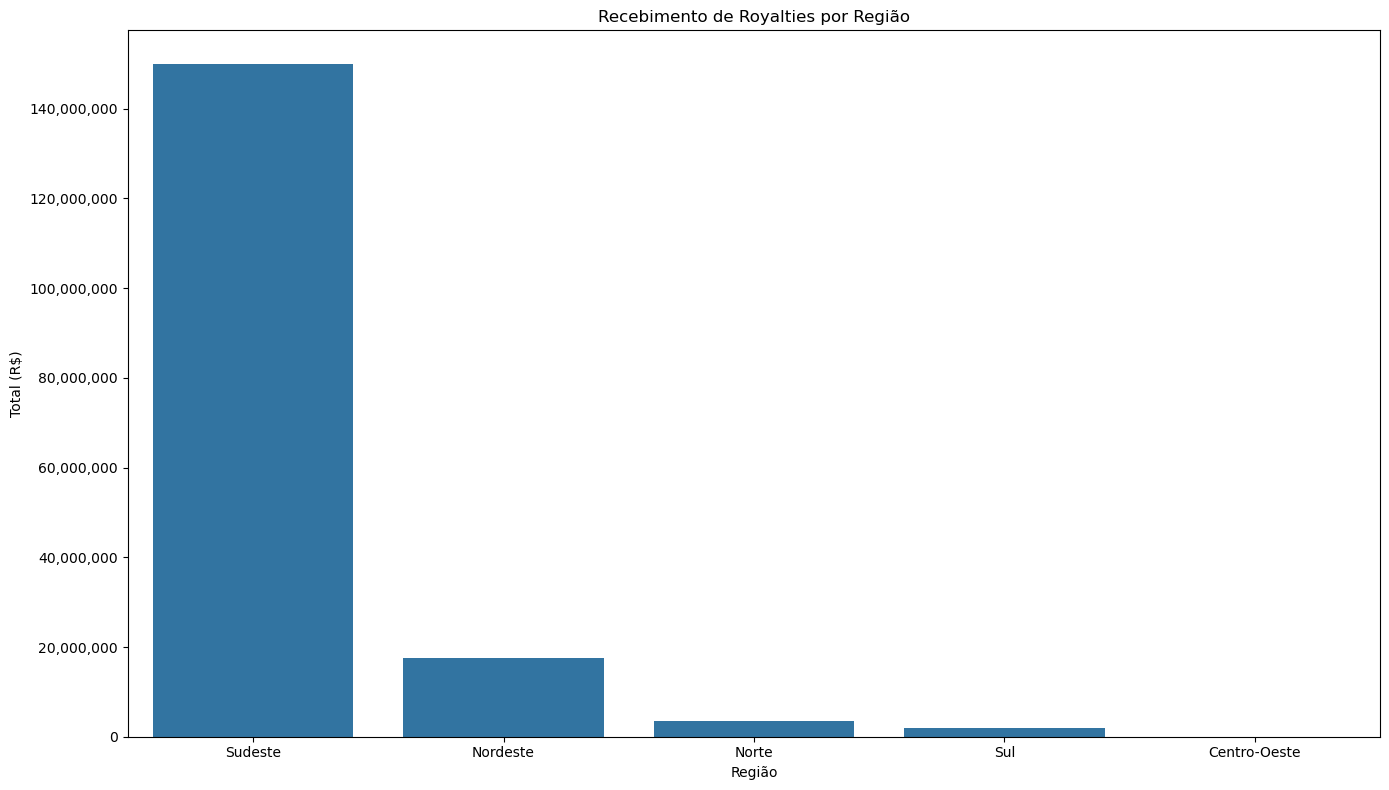

In [37]:
plt.figure(figsize=(14, 8))

ax = sns.barplot(
    data=df_resultado,
    x='regiao',
    y='distribuicao_de_royalties'
)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.title('Recebimento de Royalties por Região')
plt.ylabel('Total (R$)')
plt.xlabel('Região')
plt.tight_layout()

plt.savefig('./img/Q2_mais_e_menos_royalties.png',
            dpi=300,
            bbox_inches='tight'
            )  

plt.show()

## Questão 3
### Qual foi a evolução de royalties para beneficiários que não os estados ou os municípios desses estados?

**Funções cumpridas:**
- Uma cláusula que filtra dados usando ao menos dois operadores lógicos: usamos **not** e **and** na função `.query()`

- Uma função de conversão: utilizamos `.astype(float)` e `pd.to_datetime()` para conversões de tipo de dados

- Uma função de data: usamos `pd.to_datetime()` para conversão e `.dt.year` para extração de componente temporal

- Uma função de string: foi usado `.str.replace()` tanto para vírgulas quanto para remoção de dígitos com expressões regulares

**Explicação do Código**
- Cria uma nova cópia do DataFrame para preservar os dados originais, convertemos a coluna **distribuicao_de_royalties** que tem suas vírgulas substituídas por pontos e é convertida para tipo float.

- Filtramos os dados com diferentes operadores lógicos usando `.query()` com `not` e `and` para excluir registros que terminam com '(Estado)' ou '(Municípios)', mantendo apenas outros tipos de beneficiários.

- Convertemos de ano para data transformando a coluna **ano** em formato datetime usando `pd.to_datetime()` com formato específico '%Y', em seguida extraímos o componente ano criando, para isso, a coluna **ano_fiscal** extraindo apenas o ano da data convertida usando a função `.dt.year`.

- Removemos todos os dígitos numéricos da coluna 'beneficiario' usando regex, mantendo apenas texto (dois valores apresentaram essa ocorrência).

In [60]:
df3 = df2.copy()

In [62]:
df_evolucao = df3.query(
    "not beneficiario.str.endswith('(Estado)') and not beneficiario.str.endswith('(Municípios)')"
).copy()

df_evolucao['data'] = pd.to_datetime(df_evolucao['ano'], format='%Y')
df_evolucao['ano_fiscal'] = df_evolucao['data'].dt.year
df_evolucao['beneficiario'] = df_evolucao['beneficiario'].str.replace(r'\d+', '', regex=True)

In [63]:
df_evolucao.to_csv('./planilhas/Q3_evolucao_anual_de_royalties.csv', index=False)

Plotagem do gráfico e exportação como "Q3_evolucao_anual_de_royalties.png"

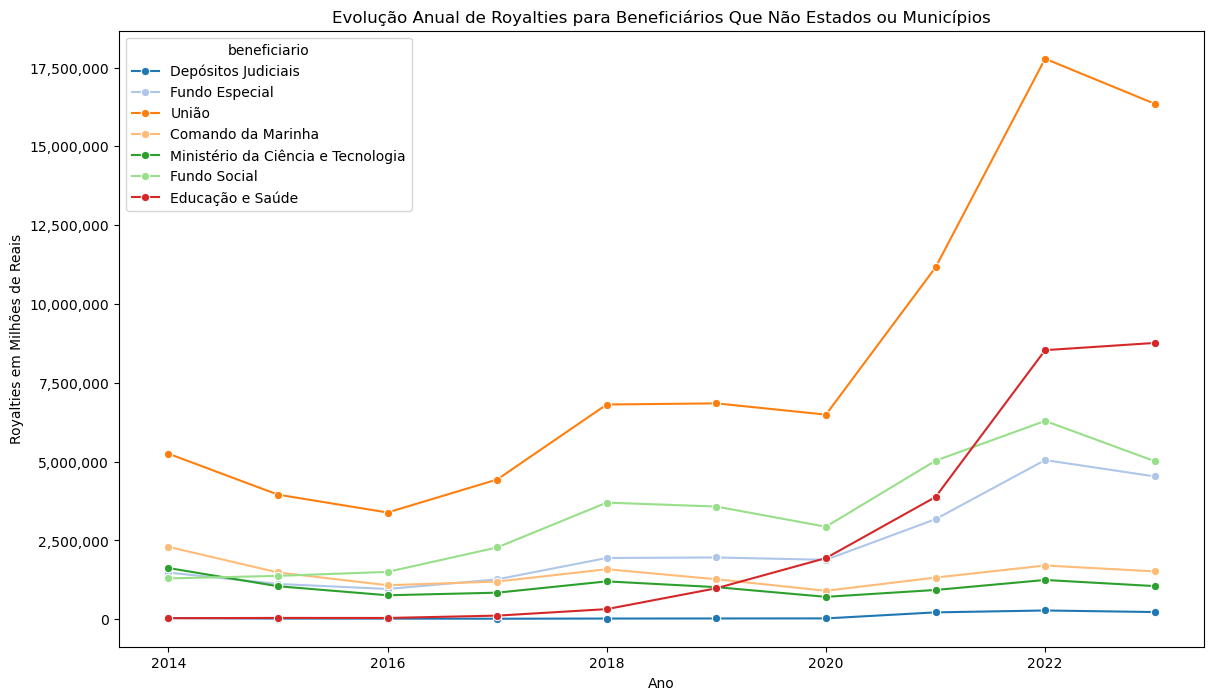

In [64]:
plt.figure(figsize=(14, 8))

ax = sns.lineplot(
    data=df_evolucao,
    x='ano',
    y='distribuicao_de_royalties',
    hue='beneficiario',
    marker='o',
    palette='tab20'
)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.title('Evolução Anual de Royalties para Beneficiários Que Não Estados ou Municípios')
plt.ylabel('Royalties em Milhões de Reais')
plt.xlabel('Ano')

plt.savefig('./img/Q3_evolucao_anual_de_royalties.png',
            dpi=300,
            bbox_inches='tight'
            )  

plt.show()

# Exportação dos Dados Localmente

In [65]:
df_final = df3.copy()

In [66]:
df_final.to_csv('../data/dataset_final.csv', index=False)